# Градиентный бустинг (AdaBoost)

#### Подсключаем библиотеки

In [25]:
import random
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Реализация алгоритма градиентного бустинга

In [26]:
# подгружаем уже заготовленный датасет из библиотеки
X, y = load_diabetes(return_X_y=True)

# Разделяем выборку на тестовую и тренеровочную
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [27]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [28]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [29]:
def bias(y, z):
    return (y - z)

In [30]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [31]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [32]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [46]:
def visual_graphics(depth, errors, range_depth, title):
    plt.xlabel(title)
    plt.ylabel('MSE')
    plt.xlim(0, depth)
    plt.plot(list(range_depth), errors)
    plt.show()

## Задание №1

### Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [34]:
def fit_predict(n_trees, max_depth, X, y):
    eta = 0.1
    coefs = [1] * n_trees
    trees = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X, y)
        else:
            target = gb_predict(X, trees, coefs, eta)
            tree.fit(X, bias(y, target))

        trees.append(tree)
    
    prediction = gb_predict(X, trees, coefs, eta)
    return mean_squared_error(y, prediction)

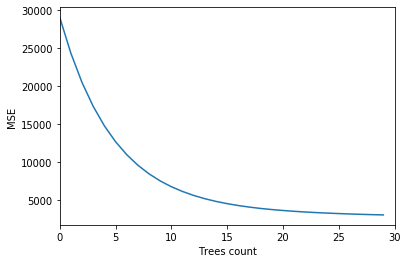

In [47]:
def plot_trees_error(n_trees, max_depth, X, y):
    errors = [fit_predict(tree, max_depth, X, y) for tree in range(n_trees)]
    visual_graphics(n_trees, errors, range(n_trees), 'Trees count')
    
plot_trees_error(30, 1, X, y)

#### Вывод: Чем больше деревьев, тем меньше ошибка

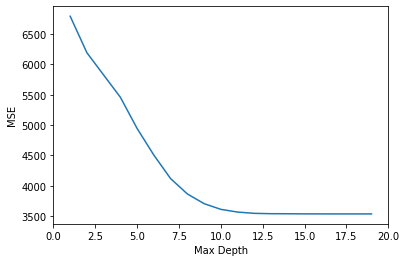

In [48]:
def plot_depth_error(n_trees, max_depth, X, y):
    errors = [fit_predict(n_trees, dep, X, y) for dep in range(1, max_depth)]
    visual_graphics(max_depth, errors, range(1, max_depth), 'Max Depth')
    
plot_depth_error(10, 20, X, y)

#### Вывод: При увеличение глубины каждого дерева, ошибка сначала уменьшается, а потом стабилизируется.

## Задание №2

### Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [49]:
def get_subsample(X, y, ratio=0.5):
    total = len(X)
    ind = list(range(total))
    random.shuffle(ind)
    n_sample = round(total * ratio)
    ind = ind[:n_sample]
    return X[ind], y[ind]

In [51]:
def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # берем подвыборку
        X_sample, y_sample = get_subsample(X, y)

        if len(trees) == 0:
            tree.fit(X_sample, y_sample)
        else:
            target = gb_predict(X_sample, trees, coefs, eta)
            tree.fit(X_sample, bias(y_sample, target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [53]:
max_depth = 5
n_trees = 50
eta = 0.1
coefs = [1] * n_trees

trees, train_errors, test_errors = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [54]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 702.0133014842218
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 655.7218760622519


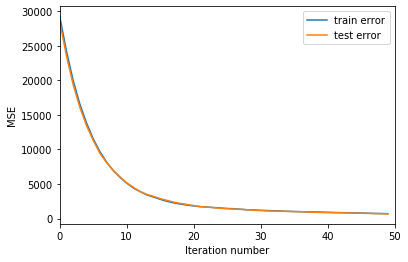

In [55]:
get_error_plot(n_trees, train_errors, test_errors)